In [19]:
from twitch import TwitchClient
import tweepy
import pandas as pd
import requests
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret,twitch_client_id)

from datetime import timedelta

client = TwitchClient(client_id=twitch_client_id)
#channel = client.channels.get_by_id(44322889)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
currtime = datetime.datetime.now().strftime('%m/%d/%y')



In [2]:
games = len(client.games.get_top())
top_games = []
popularity = []
viewers = []
channels = []
for i in range(games):
    top_games.append(client.games.get_top()[i]['game']['name'])
    popularity.append(client.games.get_top()[i]['game']['popularity'])
    viewers.append(client.games.get_top()[i]['viewers'])
    channels.append(client.games.get_top()[i]['channels'])



df = pd.DataFrame({
    'Game' : top_games,
    'Popularity' : popularity,
    'Views': viewers,
    'Channels': channels
}
)

datestamp = datetime.datetime.now().strftime('%m_%d_%y')
df.to_csv(f'game_data_{datestamp}.csv')


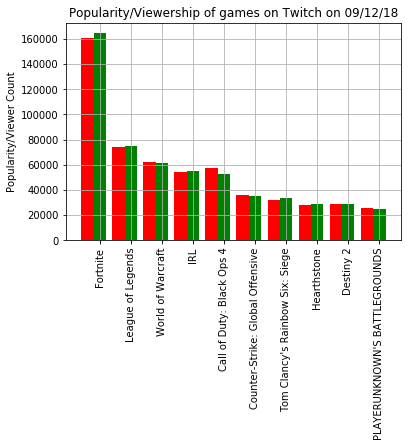

In [3]:
x = np.arange(len(df['Game']))
fig,ax = plt.subplots()

ax.bar(x -0.4 ,df['Popularity'],color='red',align='center',width = 0.4)
ax.bar(x,df['Views'],color='green',align='center',width = 0.4)
ax.set_xticks(x,df['Game'].tolist())
ax.set_ylabel('Popularity/Viewer Count')
ax.grid()
ax.set_title(f'Popularity/Viewership of games on Twitch on {currtime}')
plt.xticks(x,df['Game'].tolist(), rotation=90)
plt.savefig('bar_GamePopularityVsView.png')
plt.show()

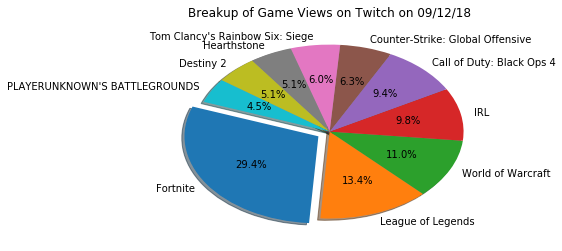

In [4]:
explode=[0.1,0,0,0,0,0,0,0,0,0]
plt.pie(df['Views'],labels=df['Game'].tolist(),shadow=True,startangle=160,explode=explode, autopct='%.1f%%')
plt.title(f'Breakup of Game Views on Twitch on {currtime}')
plt.savefig('pie_GameViewsOnTwitch.png')
plt.show()

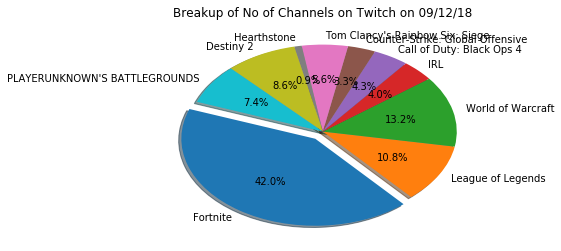

In [5]:
explode=[0.1,0,0,0,0,0,0,0,0,0]
plt.pie(df['Channels'],labels=df['Game'].tolist(),shadow=True,startangle=160,explode=explode, autopct='%.1f%%')
plt.title(f'Breakup of No of Channels on Twitch on {currtime}')
plt.savefig('pie_GameChannelsOnTwitch.png')
plt.show()

In [50]:
#Run twitter analysis

games = df['Game'].tolist()
counter = 0
gamelist=[]
texts=[]
location=[]
sentiments=[]
tweets_apart=[]
created=[]
createdFormatted=[]

for game in games:
    oldest_tweet = None
    for x in range(5):
        public_tweets = api.search(game, 
                               count=100, 
                               result_type="recent", 
                               max_id=oldest_tweet)
        for tweet in public_tweets["statuses"]:
            gamelist.append(game)
            texts.append(tweet['text'])
            #location.append(tweet['location'])
            analysis = analyzer.polarity_scores(tweet['text'])
            sentiments.append(analysis['compound'])
            created.append(tweet['created_at']) 
            createdFormatted.append(datetime.datetime.strptime(tweet['created_at'], "%a %b %d %H:%M:%S %z %Y"))
            oldest_tweet = tweet["id"] - 1
    






In [51]:

df_tweets = pd.DataFrame({
    'Games': gamelist,
    'Tweet Text': texts,
    'Sentiments': sentiments,
    'Created At': created,
    'Created At Formatted':createdFormatted
}
)
df_tweets.head()

,Games,Tweet Text,Sentiments,Created At,Created At Formatted
0,Fortnite,I hate how console builders always there bio w...,-0.5719,Thu Sep 13 05:01:08 +0000 2018,2018-09-13 05:01:08+00:00
1,Fortnite,I liked a @YouTube video https://t.co/vrpCW8iy...,0.4215,Thu Sep 13 05:01:08 +0000 2018,2018-09-13 05:01:08+00:00
2,Fortnite,@Fortnite_ar تحريات كلب,0.0000,Thu Sep 13 05:01:05 +0000 2018,2018-09-13 05:01:05+00:00
3,Fortnite,AL DEZE WAPENS KAN JE UIT DE KLUIS HALEN!! HOE...,0.0000,Thu Sep 13 05:01:05 +0000 2018,2018-09-13 05:01:05+00:00
4,Fortnite,RT @FortniteBattIee: #fortnite galaxy skin giv...,0.0000,Thu Sep 13 05:01:04 +0000 2018,2018-09-13 05:01:04+00:00


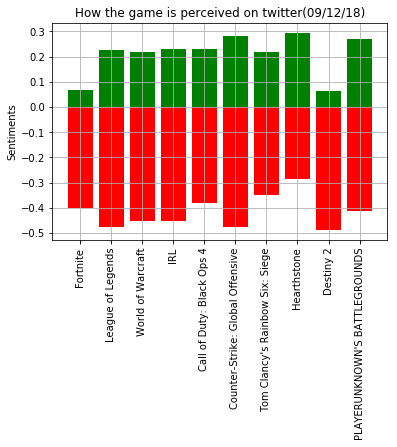

In [8]:

df_positive = df_tweets.loc[df_tweets['Sentiments'] >=0 ].groupby('Games')
df_negative = df_tweets.loc[df_tweets['Sentiments'] <0 ].groupby('Games')

x = np.arange(len(df['Game']))
fig,ax = plt.subplots()

ax.bar(x ,df_positive['Sentiments'].mean(),color='green',align='center',width = 0.8)
ax.bar(x,df_negative['Sentiments'].mean(),color='red',align='center',width = 0.8)
ax.set_xticks(x,df['Game'].tolist())
ax.set_ylabel('Sentiments')
ax.grid()
ax.set_title(f'How the game is perceived on twitter({currtime})')
plt.xticks(x,df['Game'].tolist(), rotation=90)
plt.savefig('GameTweetAnalysis.png')
plt.show()

In [9]:
base_url = 'https://contextualwebsearch.com/api/Search/WebSearchAPIWithPagination?q='
search_counts = []
for g in games:
    
    resp = requests.get(f'{base_url}{g}').json()
    search_counts.append(resp['totalCount'])
    
df_searches = pd.DataFrame({
    'Games': games,
    'Search Counts': search_counts
}
)   



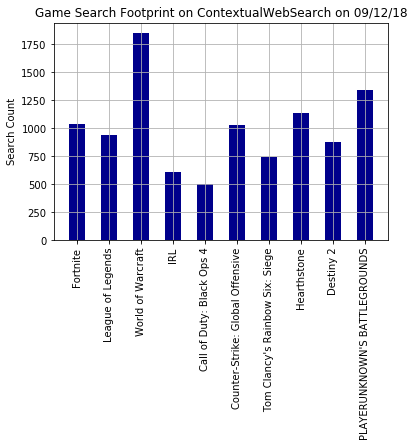

In [10]:
x = np.arange(len(df_searches['Games']))
fig,ax = plt.subplots()

ax.bar(x,df_searches['Search Counts'],color='darkblue',align='center',width = 0.5)
ax.set_xticks(x,df_searches['Games'].tolist())
ax.set_ylabel('Search Count')
ax.grid()
ax.set_title(f'Game Search Footprint on ContextualWebSearch on {currtime}')
plt.xticks(x,df_searches['Games'].tolist(), rotation=90)
plt.savefig('bar_GameSearch.png')
plt.show()

In [11]:
df_hist = pd.read_csv('game_hist.csv')


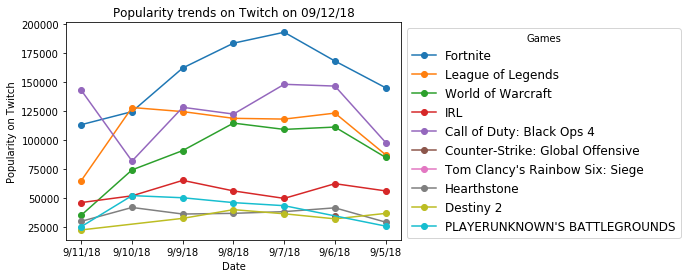

In [32]:
for g in games:

    x_axis = df_hist.loc[df_hist['Game'] == g]['Date']
    y_axis = df_hist.loc[df_hist['Game'] == g]['Popularity']
    plt.xlabel('Date')
    plt.ylabel('Popularity on Twitch')
    plt.title(f'Popularity trends on Twitch on {currtime}')
    #plt.xlim(min(x_axis),max(x_axis))
    plt.plot(x_axis,y_axis, marker='o',label=g)
    plt.legend(bbox_to_anchor=(1, 1), loc=2,fontsize="large", title="Games")

plt.savefig('trends_lastweek.png')

plt.show()    

In [66]:

#d = datetime.datetime.strptime(datetime.datetime.now(), "%a %b %d %H:%M:%S %z %Y")


df_previous = df_tweets.copy()

tweets_apart = []
tweet_creation=[]
game_list = []
for g in games:
    createdat= df_previous.loc[df_previous['Games'] == g]['Created At Formatted']
    createdat = createdat.tolist()
    for x in range(len(createdat)-1):
        game_list.append(g)
        tweets_apart.append((createdat[x] - createdat[x+1]).seconds)
        tweet_creation.append(createdat[x])


df_velocity = pd.DataFrame({
    'Games': game_list,
    'Tweets Apart':tweets_apart,
    'Tweet Created At': tweet_creation
}
)

df_velocity

,Games,Tweets Apart,Tweet Created At
0,Fortnite,0,2018-09-13 05:01:08+00:00
1,Fortnite,3,2018-09-13 05:01:08+00:00
2,Fortnite,0,2018-09-13 05:01:05+00:00
3,Fortnite,1,2018-09-13 05:01:05+00:00
4,Fortnite,0,2018-09-13 05:01:04+00:00
5,Fortnite,2,2018-09-13 05:01:04+00:00
6,Fortnite,2,2018-09-13 05:01:02+00:00
7,Fortnite,2,2018-09-13 05:01:00+00:00
8,Fortnite,0,2018-09-13 05:00:58+00:00
9,Fortnite,1,2018-09-13 05:00:58+00:00


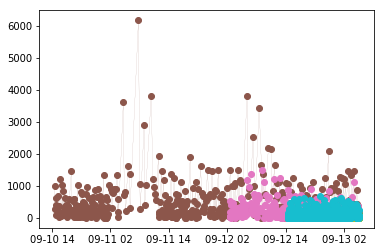

In [69]:
for g in games:
    x_axis = df_velocity.loc[df_velocity['Games'] == g]['Tweet Created At']
    y_axis = df_velocity.loc[df_velocity['Games'] == g]['Tweets Apart']
    plt.plot(x_axis,y_axis,marker='o',linewidth='0.1')

plt.show()